## Homework #5 ##
### Particle Swarm Optimization ###

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
class particle:
    def __init__(self, x, v):
        self.x = x
        self.v = v
        self.x_best = self.x

In [179]:
def particle_swarm_optimization(func, population, k_max, w=0.5, c1=0.25, c2=2.0):
    n = population[0].x.size
    shape = population[0].x.shape
    result_by_iteration = []
    
    x_best, y_best = population[0].x_best.copy(), float("inf")
    w_max, w_min = w, w
    for P in population:
        y = func(np.argsort(P.x))
        if y < y_best:
            x_best = P.x.copy()
            y_best = y
    
    for k in range(k_max):
        k_sum = 0
        for P in population:
            r1 = np.random.uniform(0, 1, size=shape)
            r2 = np.random.uniform(0, 1, size=shape)
            
            P.x = np.copy(P.x) + np.copy(P.v)
            P.v = w * np.copy(P.v) + c1 * r1 * (np.copy(P.x_best) - np.copy(P.x)) + c2 * r2 * (x_best - np.copy(P.x))
            P.v = np.clip(P.v, -(shape[1]-1), shape[1]-1)
            
            y = func(np.argsort(P.x))
            if y < y_best:
                x_best = P.x.copy()
                y_best = y
            if y < func(np.argsort(P.x_best)):
                P.x_best = P.x.copy()
            
            w = w_max - (w_max - w_min) / k_max * (k + 1)
            if w < w_min:
                w_min = w
            
            k_sum += y
            k_mean = k_sum / len(population)
            
        result_by_iteration.append(k_mean)
    
    return population, np.array(result_by_iteration)

In [206]:
class JSSP:
    '''
    m machines, n jobs, each machine need to finish jobs with specific orders
    '''
    def __init__(self, n, m, Processing_time, randopt=False, low=1, high=20):
        self.m_machine = m
        self.n_job = n
        self.Processing_time = Processing_time
        if randopt:
            self.Processing_time = self.generate_rand_proc(low, high)
        
        assert self.Processing_time.shape == (self.n_job, self.m_machine)

    def generate_rand_proc(self, low, high):
        return np.random.randint(low, high, size=(self.n_job, self.m_machine))

    def generate_rand_seq(self):
        return np.array([np.random.permutation(self.m_machine) for _ in range(self.n_job)])
    
    def generate_rand_velocity(self):
        return np.random.uniform(low=-(self.m_machine-1), high=self.m_machine-1, size=(self.n_job,self.m_machine))
    
    def PSO(self, particle_count):
        particles = [particle(self.generate_rand_seq(), self.generate_rand_velocity()) for _ in range(particle_count)]
        retval, results = particle_swarm_optimization(self.get_end_time, particles, 100)
        return retval, results
    
    def get_end_time(self, Seq):
        '''
        Seq is nxm that each row lists the machines that the job will do in order
        '''
        assert Seq.shape == (self.n_job, self.m_machine)
        machine_end_time = np.zeros(self.m_machine)
        job_end_time = np.zeros(self.n_job)
        for j in range(self.m_machine):
            for i in range(self.n_job):
                machine = int(Seq[i, j])
                # print(machine, i)
                end = max(machine_end_time[machine], job_end_time[i]) + self.Processing_time[i, j]
                machine_end_time[machine] = end
                job_end_time[i] = end
                # print(machine_end_time, job_end_time, end)
        return np.max(machine_end_time)

    def schedule_efficiency(self, Seq):
        '''
        Scheduling efficiency can be defined for a schedule through the ratio
        of total machine idle time to the total processing time
        '''
        end_time = self.get_end_time(Seq)
        total_processing_time = end_time * self.m_machine
        idle_time = total_processing_time - np.sum(self.Processing_time)
        return idle_time / total_processing_time


    def plot(self, Seq):
        fig, ax = plt.subplots()
        cmap = plt.cm.get_cmap("summer", self.n_job)(np.linspace(0.15, 0.85, self.n_job))

        machine_end_time = np.zeros(self.m_machine)
        job_end_time = np.zeros(self.n_job)
        for j in range(self.m_machine):
            for i in range(self.n_job):
                machine = int(Seq[i, j])
                end = max(machine_end_time[machine], job_end_time[i]) + self.Processing_time[i, j]
                ax.barh(machine, color=cmap[i], width=self.Processing_time[i, j],
                        left=max(machine_end_time[machine], job_end_time[i]))

                machine_end_time[machine] = end
                job_end_time[i] = end

        blocks = [mpatches.Patch(color=cmap[i], label="Job "+str(i)) for i in range(self.n_job)]
        ax.legend(handles=blocks, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_yticks(range(self.m_machine))
        ax.set_yticklabels(['Machine ' + str(i + 1) for i in range(self.m_machine)])
        ax.set_xlabel("time")
        plt.show()
        return fig

In [ ]:
proc_time = np.array([[1,4,2,1],[2,3,6,2],[3,7,2,3],[4,1,5,8]])

[Text(0, 0.5, 'Makespan'), Text(0.5, 0, 'iterations')]

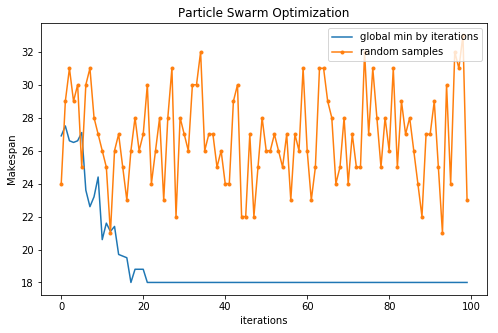

In [296]:
job = JSSP(4,4,proc_time,False)

Seq = [job.generate_rand_seq() for _ in range(10)]

opts, results = job.PSO(10)
new_seq = [job.generate_rand_seq() for _ in range(100)]
rand_time = np.array([job.get_end_time(s) for s in new_seq])

_, axs = plt.subplots(1,1,figsize=(8,5))
axs.set_title('Particle Swarm Optimization')
axs.plot(results, label = "global min by iterations")
axs.plot(rand_time, '.-',label = "random samples")
axs.legend(loc='upper right')
axs.set(xlabel='iterations', ylabel='Makespan')

18.0


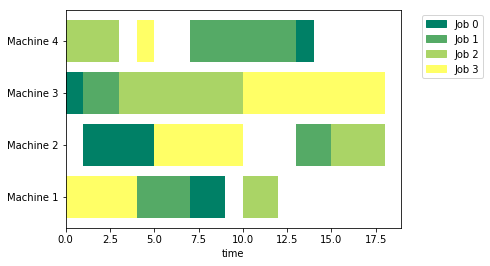

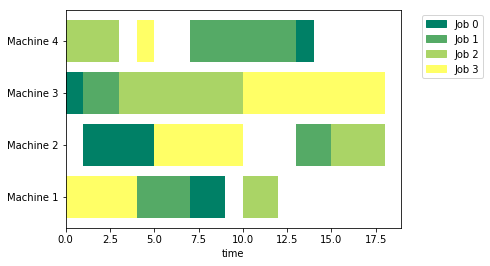

In [297]:
print(job.get_end_time(np.argsort(opts[0].x)))
job.plot(np.argsort(opts[0].x))

In [247]:
np.argsort(opts[0].x)

array([[0, 1, 2, 3],
       [1, 3, 2, 0],
       [3, 0, 2, 1],
       [0, 2, 1, 3]], dtype=int64)

In [303]:
from time import time
from random import choices, random, randint
from copy import deepcopy


def init_rand_population(size, m, n):
    basic = [i for i in range(m) for _ in range(n)]
    return [np.random.permutation(basic) for _ in range(size)]


def c_to_seq(chromosome, model):
    m = model.m_machine
    n = model.n_job
    seq = np.zeros((n, m))
    job_end = np.zeros(m).astype(int)
    order_end = np.zeros(n).astype(int)
    for c in chromosome:
        job = job_end[c]
        order = order_end[job]
        seq[job, order] = c
        job_end[c] += 1
        order_end[job] += 1
    return seq

def fitness_function_JSSP(chromosome, model):
    seq = c_to_seq(chromosome, model)
    return model.get_end_time(seq)


def select(population, fitnesses, num):
    fitnesses = np.max(fitnesses) - fitnesses
    return [tuple(choices(population, weights=fitnesses, k=3)) for _ in range(num)]


def fix(c, n, m):
    count = np.zeros(m).astype(int)
    for i in range(len(c)):
        count[c[i]] += 1
    less = [i for i in range(m) for _ in range(n-count[i]) if count[i] < n]
    for i in range(len(c)):
        if count[c[i]] > n:
            count[c[i]] -= 1
            c[i] = less.pop()
    return c


def TwoPointcrossover(a, b):
    i = randint(0, len(a)-1)
    j = randint(0, len(a)-1)
    if i > j:
        i, j = j, i
    return np.hstack((a[:i], b[i:j], a[j:])), np.hstack((b[:i], a[i:j], b[j:]))


def OnePointcrossover(a, b):
    i = randint(0, len(a)-1)
    return np.hstack((a[:i], b[i:])), np.hstack((b[:i], a[i:]))


def multi_crossover(a, b, c, model, Rc):
    ''' Algorithm 1'''
    m = model.m_machine
    n = model.n_job
    ci = [a, b, c]
    for k in range(3):
        if k == 0:
            p1, p2 = a, b
        elif k == 1:
            p1, p2 = a, c
        else:
            p1, p2 = b, c
        fp1, fp2 = fitness_function_JSSP(p1, model), fitness_function_JSSP(p2, model)
        fi = np.inf
        for i in range(Rc):
            method = randint(0, 1)
            if method == 1:
                c1, c2 = TwoPointcrossover(p1, p2)
            else:
                c1, c2 = OnePointcrossover(p1, p2)
            c1, c2 = fix(c1, n, m), fix(c2, n, m)
            fc1, fc2 = fitness_function_JSSP(c1, model), fitness_function_JSSP(c2, model)
            if fc1 < fc2:
                fi = fc1
                ci[k] = c1
            elif fc2 < fc1:
                fi = fc2
                ci[k] = c2
            if fi < fp1 or fi < fp2:
                break
    return ci


def Swapmutate(child, i, j):
    child[i], child[j] = child[j], child[i]
    return child


def insertmutate(child, i, j):
    c = child[j]
    child = np.insert(np.delete(child, j), i, c)
    return child


def mutate(children, model, max_mutat, els=0.95):
    '''Algorithm 2'''
    ret = []
    func = Swapmutate if randint(0,1)==0 else insertmutate
    for i in range(len(children)):
        c = children[i]
        if random() > els:
            fc = fitness_function_JSSP(c, model)
            for i in range(max_mutat):
                r1 = randint(0, len(c)-1)
                r2 = randint(0, len(c)-1)
                while r1 == r2:
                    r2 = randint(0, len(c) - 1)
                cc = func(c, r1, r2)
                fcc = fitness_function_JSSP(cc, model)
                if fcc < fc:
                    c = cc
                    fc = fcc
        else:
            r1 = randint(0, len(c) - 1)
            r2 = randint(0, len(c) - 1)
            while r1 == r2:
                r2 = randint(0, len(c) - 1)
            c = func(c, r1, r2)
        ret.append(c)
    return ret


def improve_crossover(population, model):
    func = Swapmutate if randint(0,1)==0 else insertmutate
    N = model.m_machine*model.n_job
    for p in range(len(population)):
        fc = fitness_function_JSSP(population[p], model)
        c = population[p]
        for i in range(N):
            for j in range(N):
                cc = func(c, i, j)
                fcc = fitness_function_JSSP(cc, model)
                if fcc < fc:
                    c = cc
                    fc = fcc
        population[p] = c
    return population


def genetic_algorithm(model, max_iter=50, pop_size=100, max_crossover=10):
    population = init_rand_population(pop_size, model.m_machine, model.n_job)
    best_fit = np.inf
    ys = []
    start = time()
    best = None
    for k in range(max_iter):
        fitnesses = np.array([fitness_function_JSSP(p, model) for p in population])
        if np.min(fitnesses) < best_fit:
            best_fit = np.min(fitnesses)
            best = population[np.argmin(fitnesses)]
        ys.append(best_fit)

        parents = select(population, fitnesses, pop_size//3)
        children = []
        for p in parents:
            children += multi_crossover(p[0], p[1], p[2], model, Rc=max_crossover)
        population = mutate(children, model, 10, els=0.95)
        population = improve_crossover(population, model)
    return c_to_seq(best, model), [ys, time() - start]

[[2. 1. 0. 3.]
 [2. 0. 3. 1.]
 [3. 2. 0. 1.]
 [0. 3. 1. 2.]]
18.0


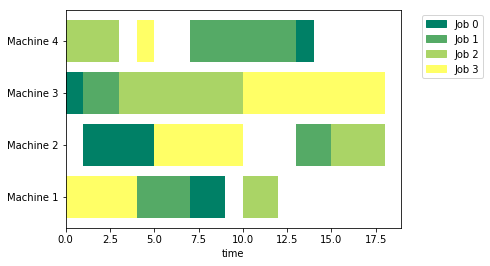

[Text(0, 0.5, 'Makespan'), Text(0.5, 0, 'iterations')]

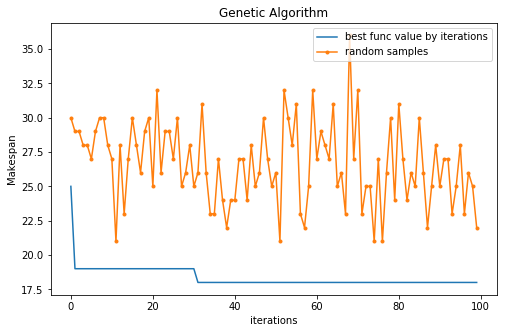

In [305]:
model = JSSP(4, 4, Processing_time=proc_time)
res, stats = genetic_algorithm(model, max_iter=100, pop_size=4)
print(model.get_end_time(res))
model.plot(res)
new_seq = [job.generate_rand_seq() for _ in range(100)]
rand_time = np.array([job.get_end_time(s) for s in new_seq])

_, axs1 = plt.subplots(1,1,figsize=(8,5))

axs1.set_title('Genetic Algorithm')
axs1.plot(stats[0], label = "best func value by iterations")
axs1.plot(rand_time, '.-',label = "random samples")
axs1.legend(loc='upper right')
axs1.set(xlabel='iterations', ylabel='Makespan')

In [306]:
res

array([[2., 1., 0., 3.],
       [2., 0., 3., 1.],
       [3., 2., 0., 1.],
       [0., 3., 1., 2.]])

In [326]:
import random
import math

def findNeighbours(seq):
    nbrs = []
    M,N = seq.shape
    for i in range(M):
        for j in range(N - 1):
            nbr = seq[:]
            nbr[i][j], nbr[i][j+1] = nbr[i][j+1], nbr[i][j]
            nbrs.append(nbr)
    return nbrs


def simulatedAnnealing(job, T, maxIter, halting, decrease):
    seq = job.generate_rand_seq()
    ys = []
    for i in range(halting):
        T = decrease * float(T)

        for j in range(maxIter):
            cost = job.get_end_time(seq)

            for k in findNeighbours(seq):
                k_cost = job.get_end_time(k)
                if k_cost < cost:
                    seq = k
                    cost = k_cost
                else:
                    p = math.exp(-k_cost / T)
                    if random.random() < p:
                        seq = k
                        cost = k_cost
            ys.append(cost)
    return cost, seq, np.array(ys)

In [327]:
cost, seq, ys = simulatedAnnealing(model, 200, 100, 10, 0.8)
print(cost)

28.0


In [330]:
ys

array([27., 25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27.,
       25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27., 25.,
       25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27., 25., 25.,
       28., 27., 25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28.,
       27., 25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27.,
       25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27., 25.,
       25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27., 25., 25.,
       28., 27., 25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28.,
       27., 25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27.,
       25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27., 25.,
       25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27., 25., 25.,
       28., 27., 25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28.,
       27., 25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27.,
       25., 25., 28., 27., 25., 25., 28., 27., 25., 25., 28., 27